In [0]:
##Opening Data And saving

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

!ls '/content/drive/My Drive/4º Curso/DeepLearning/DeepLearningLabs/Lab5/data/'
myDrive = '/content/drive/My Drive/4º Curso/DeepLearning/DeepLearningLabs/Lab5/data/'
myRoot = '/content/drive/My Drive/4º Curso/DeepLearning/DeepLearningLabs/Lab5/'
%run /content/drive/My\ Drive/4º\ Curso/DeepLearning/DeepLearningLabs/Lab5/Datasets.py

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
AEMnist  CK  CVAECK  GANCK  GANMnist  mnist  MNIST_DAE	samples


In [0]:
import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np

CUDA = True
SEED = 1
BATCH_SIZE = 128
LOG_INTERVAL = 10
EPOCHS = 7
no_of_sample = 10
ZDIMS = 2

# directory to save results
dirTarget = myRoot+'results/CVAE/'

torch.manual_seed(SEED)
if CUDA:
    torch.cuda.manual_seed(SEED)

# DataLoader instances will load tensors directly into GPU memory
kwargs = {'num_workers': 1, 'pin_memory': True} if CUDA else {}
input_size = 64

data_transforms = transforms.Compose([
        transforms.Resize((input_size,input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

CKD = CKDataset(troot = myDrive+"CK/",transform = data_transforms)
train_loader = torch.utils.data.DataLoader(CKD, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(CKD, batch_size=BATCH_SIZE, shuffle=True)


In [0]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(4, 4), padding=(15, 15), stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(4, 4), padding=(15, 15), stride=2)
        self.fc11 = nn.Linear(in_features=128 * 37 * 37, out_features=1024)
        self.fc12 = nn.Linear(in_features=1024, out_features=ZDIMS)

        self.fc21 = nn.Linear(in_features=128 * 37 * 37, out_features=1024)
        self.fc22 = nn.Linear(in_features=1024, out_features=ZDIMS)
        self.relu = nn.ReLU()

        # For mu
        self.fc1 = nn.Linear(in_features=ZDIMS, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=37 * 37 * 128)
        self.conv_t1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(4,4), padding=(15,15), stride=2)
        self.conv_t2 = nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=(4,4), padding=(15,15), stride=2)

    def encode(self, x):

        x = x.view(-1, 3, 64, 64)
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = x.view(-1, 128 * 37 * 37)
       
        mu_z = F.elu(self.fc11(x))
        mu_z = self.fc12(mu_z)

        logvar_z = F.elu(self.fc21(x))
        logvar_z = self.fc22(logvar_z)    

        return mu_z, logvar_z


    def reparameterize(self, mu, logvar):# -> Variable:


        if self.training:
            # multiply log variance with 0.5, then in-place exponent
            # yielding the standard deviation

            sample_z = []
            for _ in range(no_of_sample):
                std = logvar.mul(0.5).exp_()  # type: Variable
                eps = Variable(std.data.new(std.size()).normal_())
                sample_z.append(eps.mul(std).add_(mu))

            return sample_z

        else:
            # During inference, we simply spit out the mean of the
            # learned distribution for the current input.  We could
            # use a random sample from the distribution, but mu of
            # course has the highest probability.
            return mu

    def decode(self, z) : 

        x = F.elu(self.fc1(z))
        x = F.elu(self.fc2(x))
        x = x.view(-1, 128, 37, 37)
        x = F.relu(self.conv_t1(x))
        x = torch.sigmoid(self.conv_t2(x))

        return x.view(-1, 4096)


    def forward(self, x): 
        #print(x.size())
        #print(x.view(-1, 4096).size())
        mu, logvar = self.encode(x.view(-1, 4096))
        z = self.reparameterize(mu, logvar)
        if self.training:
            return [self.decode(z) for z in z], mu, logvar
        else:
            return self.decode(z), mu, logvar
        # return self.decode(z), mu, logvar
        
        
    def forward_w_mu_std(self, mu,logvar):
        z = self.reparameterize(mu, logvar)
        if self.training:
            return [self.decode(z) for z in z], mu, logvar
        else:
            return self.decode(z), mu, logvar
        # return self.decode(z), mu, logvar

    def loss_function(self, recon_x, x, mu, logvar):
      
        if self.training:
            BCE = 0
            for recon_x_one in recon_x:
                #print(recon_x_one.size())
                #print(x.view(-1, 4096).size())
                BCE += F.binary_cross_entropy(recon_x_one, x.view(-1, 4096))
            BCE /= len(recon_x)
        else:
            BCE = F.binary_cross_entropy(recon_x, x.view(-1, 4096))
        #KLD is Kullback-Leibler divergence how much does one learned
        # distribution deviate from another, in this specific case the
        # learned distribution from the unit Gaussian

        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # - D_{KL} = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        # note the negative D_{KL} in appendix B of the paper
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        # Normalise by same number of elements as in reconstruction
        KLD /= BATCH_SIZE * 784


        return BCE + KLD

In [0]:
model = VAE()
if CUDA:
    model.cuda()


optimizer = optim.Adam(model.parameters(), lr=1e-6)

In [0]:
# list to keep track of the losses on each epoch
loss_list = []

def train(epoch):
    # toggle model to train mode
    model.train()
    train_loss = 0
   
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        if CUDA:
            data = data.cuda()
        optimizer.zero_grad()

        # push whole batch of data through VAE.forward() to get recon_loss
        recon_batch, mu, logvar = model(data)
        
        # calculate scalar loss
        loss = model.loss_function(recon_batch, data, mu, logvar)
        # calculate the gradient of the loss w.r.t. the graph leaves
        # i.e. input variables -- by the power of pytorch!
        loss.backward()
        train_loss += loss.data.item()
        loss_list.append(loss.data.item() / len(data))
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader),
                       loss.data.item() / len(data)))
    
    # Save the model checkpoint
    torch.save(model.state_dict(), myRoot+'CVAE.ckpt')
    #to load : model.load_state_dict(torch.load(save_name_ori))
    
    #CNNS.load_state_dict(torch.load('models.ckpt'))
    
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0

    # each data is of BATCH_SIZE (default 128) samples
    for i, (data, _) in enumerate(test_loader):
        if CUDA:
            # make sure this lives on the GPU
            data = data.cuda()
        
        recon_batch, mu, logvar = model(data)
        
        #print('mu',mu,'logvar',logvar)
        
        test_loss += model.loss_function(recon_batch, data, mu, logvar).data.item()
        
        if i == 0:
            n = min(data.size(0), 16)
            comparison = torch.cat([data[:n],
                                    recon_batch.view(BATCH_SIZE, 3, 64, 64)[:n]])
            save_image(comparison.data.cpu(),
                       dirTarget+'recon_train_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [0]:
from PIL import Image
import matplotlib.pyplot as plt

if __name__ == "__main__":
    trainModel = True
    if not trainModel : 
        model.load_state_dict(torch.load(myRoot+'CVAE.ckpt'))
    
    
    x_values = np.linspace(-3, 3, 8)
    y_values = np.linspace(-3, 3, 8)
    
    xx,yy = np.meshgrid(x_values,y_values)
    sample = np.column_stack((xx.flatten(),yy.flatten()))
    sample = torch.from_numpy(sample).float()
    
    for epoch in range(1, EPOCHS + 1):
        if trainModel: 
            train(epoch)
            test(epoch)
            
        #print('sample',sample)
        
        if epoch == 10:
        
          if CUDA:
              sample = sample.cuda()
          sample = model.decode(sample).cpu()
          print(sample.size())
          resName = dirTarget+'recon_latent' + str(epoch) + '.png'
          save_image(sample.data.view(192, 1, 64, 64),resName)
          plt.imshow(Image.open(resName))
        
        if not trainModel : 
            break

Train Epoch: 1 [0/6849 (0%)]	Loss: 0.005797
Train Epoch: 1 [1280/6849 (19%)]	Loss: 0.005801
Train Epoch: 1 [2560/6849 (37%)]	Loss: 0.005742
Train Epoch: 1 [3840/6849 (56%)]	Loss: 0.005771
Train Epoch: 1 [5120/6849 (74%)]	Loss: 0.005758
Train Epoch: 1 [6400/6849 (93%)]	Loss: 0.005723
====> Epoch: 1 Average loss: 0.0058
====> Test set loss: 0.0058
Train Epoch: 2 [0/6849 (0%)]	Loss: 0.005714
Train Epoch: 2 [1280/6849 (19%)]	Loss: 0.005683
Train Epoch: 2 [2560/6849 (37%)]	Loss: 0.005672
Train Epoch: 2 [3840/6849 (56%)]	Loss: 0.005659
Train Epoch: 2 [5120/6849 (74%)]	Loss: 0.005641
Train Epoch: 2 [6400/6849 (93%)]	Loss: 0.005635
====> Epoch: 2 Average loss: 0.0057
====> Test set loss: 0.0057
Train Epoch: 3 [0/6849 (0%)]	Loss: 0.005631
Train Epoch: 3 [1280/6849 (19%)]	Loss: 0.005600
Train Epoch: 3 [2560/6849 (37%)]	Loss: 0.005583
Train Epoch: 3 [3840/6849 (56%)]	Loss: 0.005530
Train Epoch: 3 [5120/6849 (74%)]	Loss: 0.005517
Train Epoch: 3 [6400/6849 (93%)]	Loss: 0.005467
====> Epoch: 3 Avera

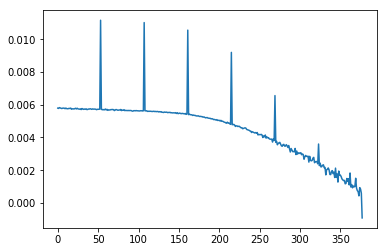

In [0]:
plt.plot(loss_list)
plt.show()